In [1]:
%run data.py

### Read hospital bed data.

In [2]:
df = fetchData(nyc_his_bed_url)
df.head(10)

,timestamp,locality,total,total_available,icu,icu_available
0,2020-03-26T04:00:00Z,state,42566,11023,4330,1027
1,2020-03-26T04:00:00Z,nyc,20394,3557,2011,307
2,2020-03-30T04:00:00Z,state,44459,11453,5470,1309
3,2020-03-30T04:00:00Z,nyc,20898,3240,2449,392
4,2020-04-01T04:00:00Z,state,44921,11438,5740,1380
5,2020-04-01T04:00:00Z,nyc,21167,3112,2565,352
6,2020-04-02T04:00:00Z,state,47324,12188,6537,1320
7,2020-04-02T04:00:00Z,nyc,22910,3975,3082,370
8,2020-04-03T04:00:00Z,state,48200,13505,6862,1331
9,2020-04-03T04:00:00Z,nyc,23957,5354,3256,419


In [3]:
#split timestamp into date and time
df[["date","time"]] =df["timestamp"].str.split("T", expand = True)

#select date, locality, icu from original data. convert string to datetime.
df = df[["date","locality","icu"]]
df["date"] = pd.to_datetime(df['date'])

#filter nyc data.
df = df[df["locality"] == "nyc"]
df.head(10)

,date,locality,icu
1,2020-03-26,nyc,2011
3,2020-03-30,nyc,2449
5,2020-04-01,nyc,2565
7,2020-04-02,nyc,3082
9,2020-04-03,nyc,3256
11,2020-04-04,nyc,3439
13,2020-04-05,nyc,3478
15,2020-04-06,nyc,3542
17,2020-04-07,nyc,3676
19,2020-04-08,nyc,3811


In [4]:
data = spark.createDataFrame(df)
data.createOrReplaceTempView("data")

### Calculate the rising rate.

In [5]:
first_data = spark.sql("SELECT icu FROM data WHERE date = \
                                (SELECT min(date) FROM data)")
first_data = first_data.rdd.map(list).take(1)[0][0]

latest_data = spark.sql("SELECT icu FROM data WHERE date = \
                                (SELECT max(date) FROM data)")
latest_data = latest_data.rdd.map(list).take(1)[0][0]

rising_rate = (latest_data - first_data) / first_data
print("rising rate is: ", rising_rate)

rising_rate = rising_rate * 100
rising_rate_str = "↑" + str('%.2f' % rising_rate) + "%"

rising rate is:  0.7722526106414719


In [6]:
print(rising_rate_str)

↑77.23%


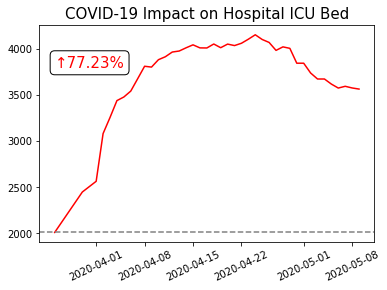

In [7]:
import matplotlib.pyplot as plt
from pandas import Timestamp

plt.close('all')

#icu bed number
plt.plot("date", "icu", data = df, color = "red")

#icu bed numbers on 2020-03-26
plt.axhline(y = first_data ,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on Hospital ICU Bed",fontsize = 15)

#annotaion: rising rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(Timestamp("2020-03-26"), 3800, rising_rate_str, size = 15, color = "red", bbox=bbox_props)

plt.xticks(rotation=25)
plt.show()